# STAT 315 Final Project  
## Spotify Track Popularity Analysis  
**Group Members:** Ayushi Sharma, Bernardo Gonzalez Guerra, Mohnish Bandari  
**Course:** STAT 315 - Fall 2025

# 1. Research Questions

Our analysis focuses on the following questions:

1. What audio features are the strongest predictors of a song being popular on Spotify?
2. Can we accurately classify whether a song falls into a “high popularity” vs. “low popularity” group based solely on its audio features?
3. How well can we predict a song’s exact popularity score using a regression model, and which features contribute most to this prediction?
4. What correlations and relationships exist among audio features, and how might these influence model performance?
5. Do certain genres or artists tend to have higher average popularity, and how do their audio profiles compare to less popular tracks?
6. How much uncertainty exists in our predictions, as measured by cross-validation and bootstrap confidence intervals?

# 2. Data Collection

## Our dataset
For this project, we are using the Spotify Tracks Dataset from Kaggle, which contains over 230,000 songs pulled from Spotify’s Web API. Each row represents a single track, and the dataset includes a mixture of audio features, metadata, and Spotify’s own popularity score. The audio features (such as danceability, energy, and acousticness) are numerical values generated by Spotify’s signal processing models that describe different musical characteristics of each track. Because the dataset is large, mostly numeric, and relatively clean, it is well suited for exploratory data analysis and predictive modeling.

## Dataset Source
This dataset is publicly available on Kaggle at:
https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db

The original data was collected through Spotify’s Web API, which provides track level audio analysis values and popularity scores.

## Variable Descriptions
Below is a list of the key variables we will be using:
- genre: Genre label associated with the track.
- artist_name: Name of the performing artist.
- track_name: Name of the song.
- track_id: Unique Spotify ID for the track.
- popularity: Spotify-defined popularity score (0–100).
- acousticness: Confidence measure of whether a track is acoustic (0.0–1.0).
- danceability: How suitable a track is for dancing (0.0–1.0).
- duration_ms: Track duration in milliseconds.
- energy: Perceived intensity and activity of the track (0.0–1.0).
- instrumentalness: Likelihood the track contains no vocals (0.0–1.0).
- key: Musical key (0–11).
- liveness: Probability the track was performed live (0.0–1.0).
- loudness: Overall loudness of the track (in decibels).
- mode: Modal quality of the track (0 = minor, 1 = major).
- speechiness: Presence of spoken words in a track (0.0–1.0).
- tempo: Estimated tempo in beats per minute (BPM).
- time_signature: Estimated time signature (e.g., 3, 4, 5).
- valence: Musical “positiveness” conveyed by the track (0.0–1.0).

## Spotify Popularity Score
Spotify’s popularity metric ranges from 0 to 100, where higher values indicate a track that is streamed more often and more recently relative to others. The score is not based on audio features; instead, it is derived from listener behavior such as stream counts, recency, playlist appearances, and user engagement. Because it reflects real-world streaming activity, this popularity score serves as a meaningful target variable for both regression and classification tasks.

## Load Spotify Dataset

In [ ]:
# Load data
import pandas as pd
import numpy as np

df = pd.read_csv('../data/SpotifyFeatures.csv')

df.head()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,232725.000000,232725.000000,232725.000000,2.327250e+05,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000
mean,41.127502,0.368560,0.554364,2.351223e+05,0.570958,0.148301,0.215009,-9.569885,0.120765,117.666585,0.454917
std,18.189948,0.354768,0.185608,1.189359e+05,0.263456,0.302768,0.198273,5.998204,0.185518,30.898907,0.260065
min,0.000000,0.000000,0.056900,1.538700e+04,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,29.000000,0.037600,0.435000,1.828570e+05,0.385000,0.000000,0.097400,-11.771000,0.036700,92.959000,0.237000
50%,43.000000,0.232000,0.571000,2.204270e+05,0.605000,0.000044,0.128000,-7.762000,0.050100,115.778000,0.444000
75%,55.000000,0.722000,0.692000,2.657680e+05,0.787000,0.035800,0.264000,-5.501000,0.105000,139.054000,0.660000
max,100.000000,0.996000,0.989000,5.552917e+06,0.999000,0.999000,1.000000,3.744000,0.967000,242.903000,1.000000


### Dataset Summary

The dataset contains **232,725 rows** and **18 columns**. Most of the variables are numeric 
features such as danceability, energy, valence, loudness, tempo, and other audio related 
attributes generated by Spotify's API. A few variables, such as `track_name`, `artist_name`, 
and `genre`, are stored as object/string types.

Numeric columns include float based audio features (danceability, energy, valence, acousticness, 
speechiness, instrumentalness, etc) as well as integer based metadata (popularity, key, 
time_signature). The object columns contain track metadata.

# 3. Data Cleaning & Preparation

This section ensures the dataset is complete, consistent, and ready for modeling. We check for missing values, remove duplicates, engineer new features, and prepare  
the final feature set used in regression and classification models.


In [ ]:
# Check missing values
df.isna().sum()

genre               0
artist_name         0
track_name          1
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

### Missing Values Summary

The missing values check shows that the dataset is almost completely full, with only 
one missing value found in the `track_name` column. Since every other column has zero 
missing entries and the dataset contains over 232,000 rows, removing this single row 
is the simplest and most appropriate approach. This ensures data consistency without 
any meaningful loss of information.


In [ ]:
# Drop rows with missing values
df = df.dropna()
df.shape

(232724, 18)

After removing the single row containing a missing value, the dataset remains large 
and complete. This prepares the data for further preprocessing and analysis.

In [ ]:
# check for and remove duplicates
df = df.drop_duplicates()
df.shape


(232724, 18)

### Duplicate Check

We checked for duplicate rows using `df.drop_duplicates()`. The shape of the dataset 
remained the same before and after this operation, indicating that there were no 
duplicate tracks present. This means the dataset is already clean with respect to 
duplicated entries.


## Creating New Features

### 1. Converting duration from milliseconds to minutes:
We convert track duration from milliseconds to minutes for better interpretability 
in visualizations and modeling.


In [ ]:
df['duration_min'] = df['duration_ms'] / 60000


### 2. Create “high_popularity” variable:
To create a balanced classification target, we define a track as "high popularity" if 
its popularity score is above the median of the dataset. This ensures an approximately 
50/50 split between high and low popularity classes. We use the median threshold, which is best for balanced classes.


In [ ]:
threshold = df['popularity'].median()
df['high_popularity'] = (df['popularity'] >= threshold).astype(int)
threshold


43.0

## Selecting Features for Modeling

In [ ]:
features = [
    'danceability', 'energy', 'valence', 'loudness', 'tempo',
    'acousticness', 'instrumentalness', 'speechiness', 'liveness',
    'duration_min'
]

X = df[features]
y_reg = df['popularity']
y_clf = df['high_popularity']


We define our feature matrix `X` using key audio characteristics that are numeric 
and suitable for regression and classification. Our regression target is the continuous 
popularity score, and our classification target is the binary high_popularity variable.


# 4. Exploratory Data Analysis (EDA)

Before building predictive models, in this section we explore the structure of the dataset and examine how Spotify audio features relate to popularity. This includes:

- distribution plots  
- correlation heatmaps  
- scatterplots  
- high vs low popularity comparisons  
- genre-level differences  

These exploratory analyses will help us anticipate model performance and understand the relationships among the features.


### Correlation Heatmap
The correlation heatmap helps identify which audio features are most closely 
associated with popularity. For example, features like loudness, energy, or 
danceability may show moderate positive correlation with popularity, while others 
such as acousticness may show weaker or negative associations.


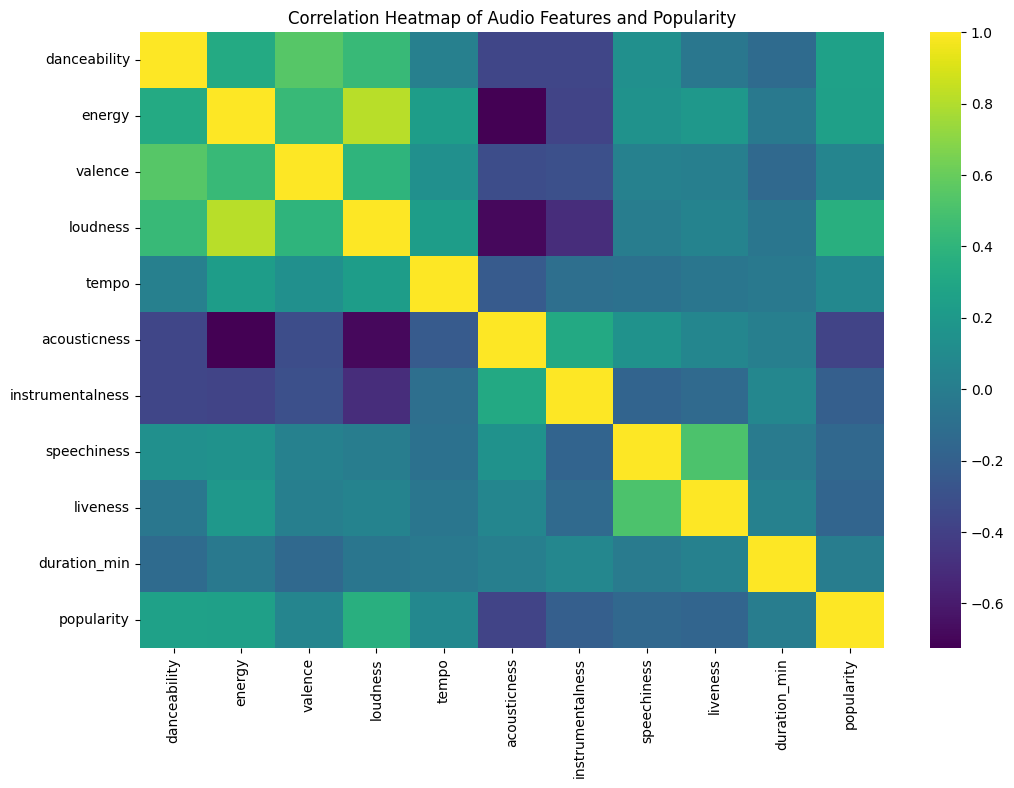

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(df[features + ['popularity']].corr(), cmap='viridis', annot=False)
plt.title('Correlation Heatmap of Audio Features and Popularity')
plt.show()


### Interpretation of Correlation Heatmap

The correlation heatmap shows that Spotify popularity is only weakly correlated with most audio features.  
Danceability, loudness, and energy have small positive correlations with popularity, while acousticness  
and instrumentalness show mild negative correlations. No feature correlates strongly with popularity,  
which suggests:

- audio features alone likely have limited predictive power  
- external factors (playlisting, marketing, artist fanbase) may drive popularity  
- regression and classification models may perform poorly  

Energy and loudness are strongly correlated with each other, reflecting that louder songs are typically  
more energetic. Acousticness is strongly negatively correlated with both, consistent with acoustic  
songs tending to be quieter and less energetic.


### Popularity Distribution
Popularity scores range from 0–100, with many tracks clustered at lower values. 
This indicates that most songs on Spotify are relatively less popular, and only 
a smaller subset achieves high popularity.



/Users/bernie/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


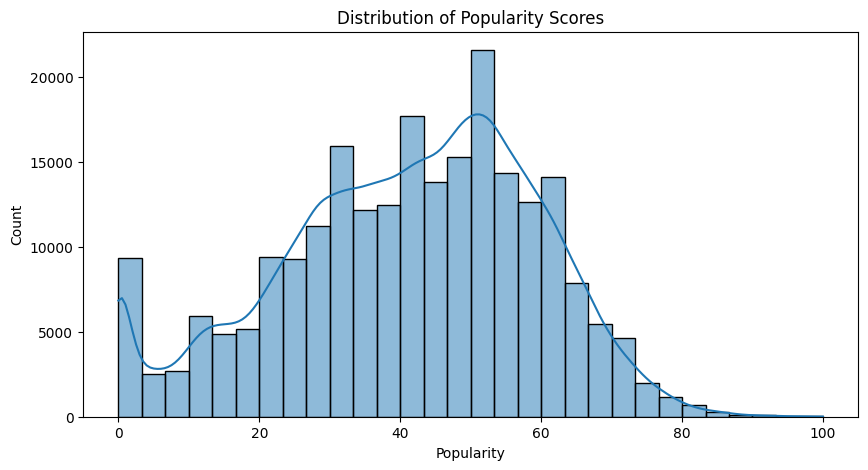

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['popularity'], kde=True, bins=30)
plt.title("Distribution of Popularity Scores")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.show()


### Audio Feature Distribution
These distributions show how Spotify's audio attributes vary across tracks. Some 
features (such as danceability and energy) follow more uniform distributions, 
while others (like acousticness or instrumentalness) show heavy skewness.


/Users/bernie/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bernie/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bernie/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bernie/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

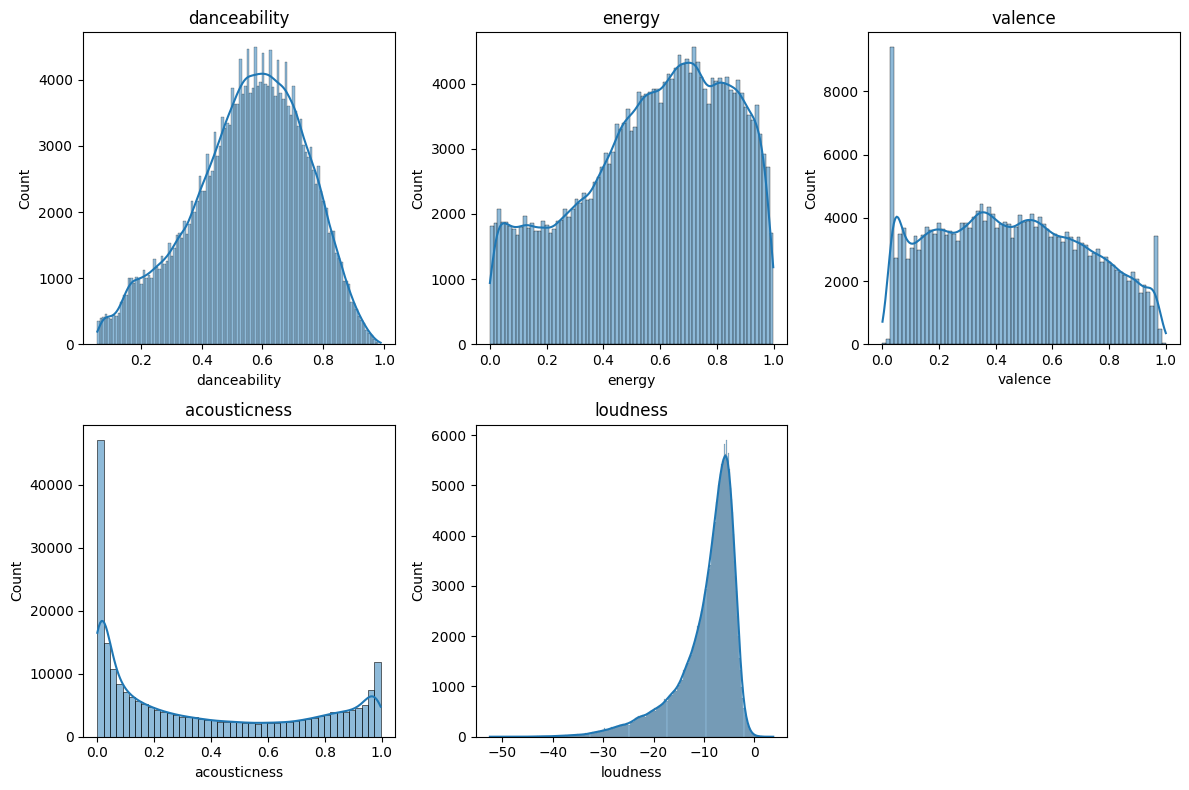

In [ ]:
cols_to_plot = ['danceability', 'energy', 'valence', 'acousticness', 'loudness']

plt.figure(figsize=(12, 8))
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()


### Interpretation of Feature Distributions

The audio features vary widely across tracks. Several features such as acousticness, speechiness,  
and instrumentalness are highly skewed, indicating that most tracks have very low values with a  
long tail of rarer examples. Popularity itself is right‐skewed, showing that only a small fraction  
of songs achieve high popularity.

These patterns indicate that the dataset contains a broad range of musical styles, and any model  
must account for this variation.


### Scatterplots vs. Popularity
Scatterplots allow us to visually check whether relationships appear linear or 
nonlinear. Some features may show mild positive relationships with popularity, 
while others show little structure.


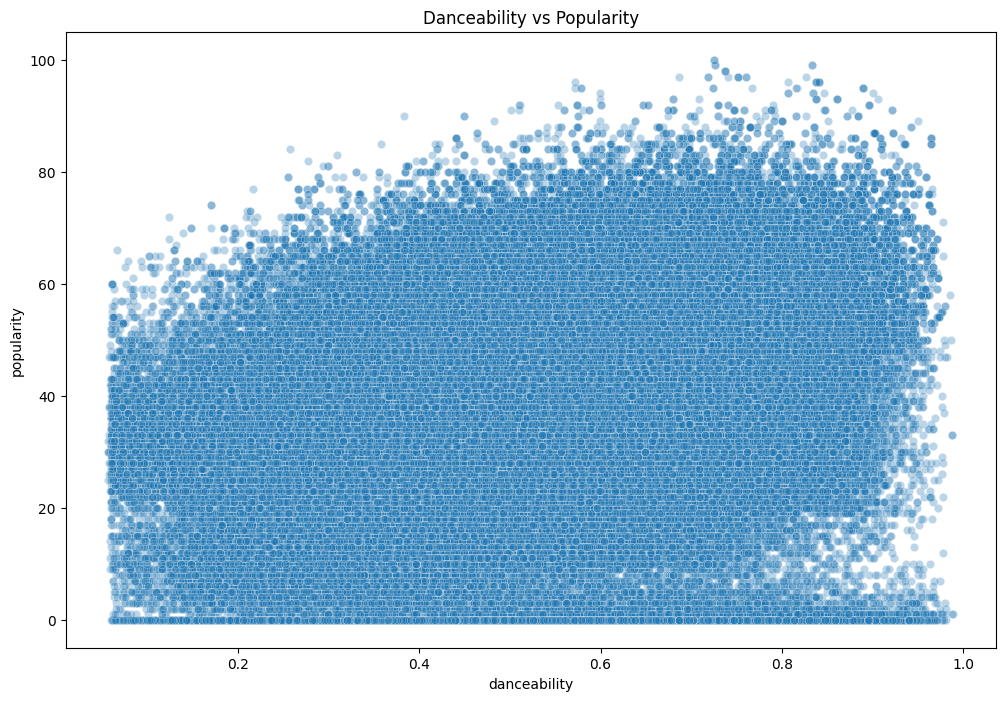

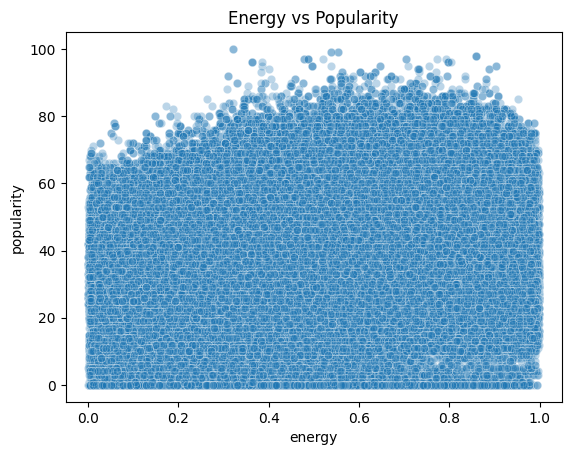

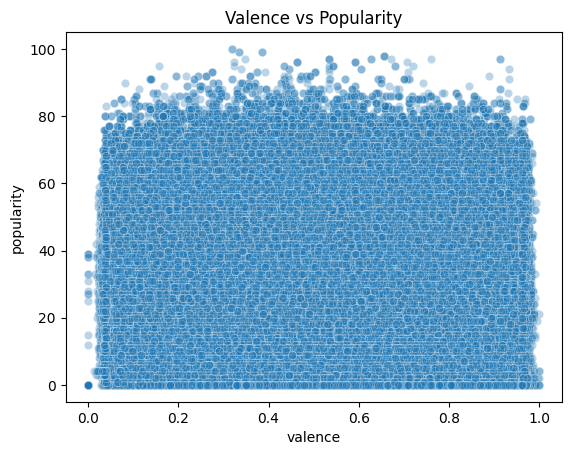

In [ ]:
plt.figure(figsize=(12, 8))

sns.scatterplot(x='danceability', y='popularity', data=df, alpha=0.3)
plt.title("Danceability vs Popularity")
plt.show()

sns.scatterplot(x='energy', y='popularity', data=df, alpha=0.3)
plt.title("Energy vs Popularity")
plt.show()

sns.scatterplot(x='valence', y='popularity', data=df, alpha=0.3)
plt.title("Valence vs Popularity")
plt.show()


### High vs. Low Popularity Comparisons
These boxplots compare the distribution of audio features between high and low 
popularity groups. Features like loudness and energy often show clear differences, 
suggesting they may play a role in predicting popularity.


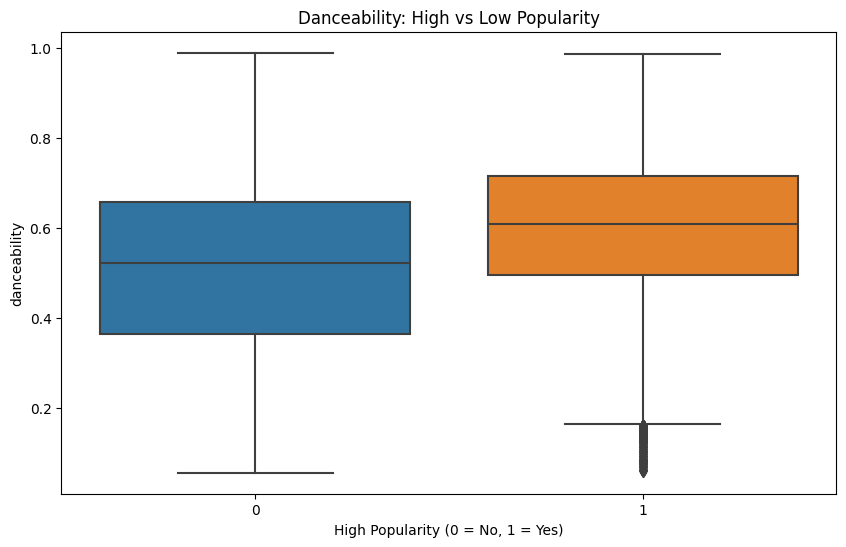

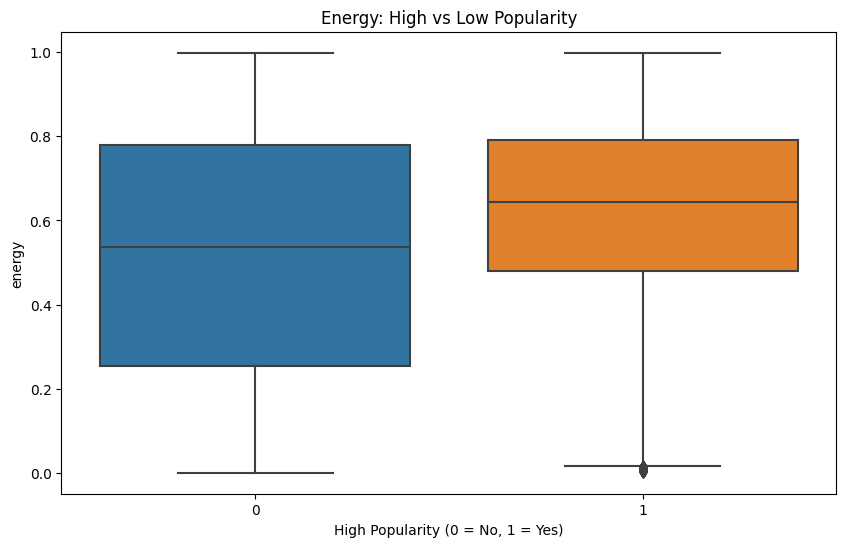

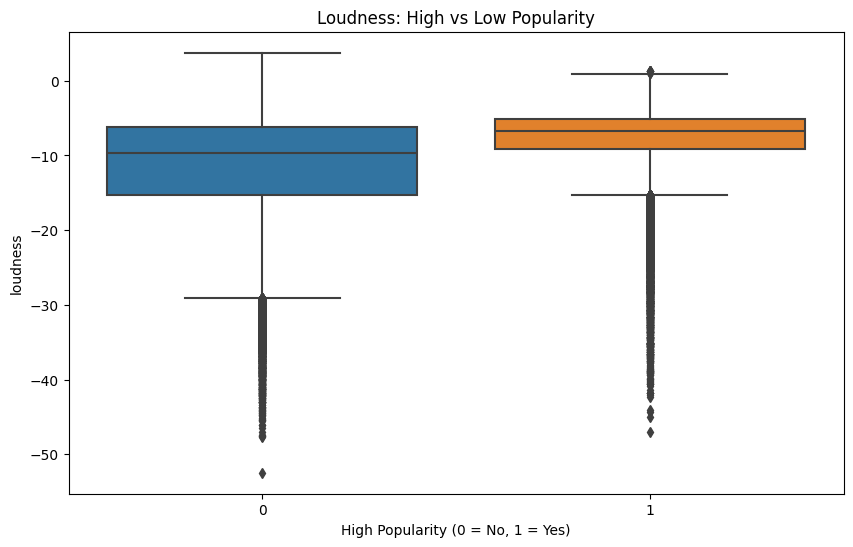

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='high_popularity', y='danceability', data=df)
plt.title("Danceability: High vs Low Popularity")
plt.xlabel("High Popularity (0 = No, 1 = Yes)")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='high_popularity', y='energy', data=df)
plt.title("Energy: High vs Low Popularity")
plt.xlabel("High Popularity (0 = No, 1 = Yes)")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='high_popularity', y='loudness', data=df)
plt.title("Loudness: High vs Low Popularity")
plt.xlabel("High Popularity (0 = No, 1 = Yes)")
plt.show()


### Genre-Level Popularity
Some genres tend to have higher average popularity than others. This analysis helps 
identify genre-level trends and supports further questions about how musical style 
relates to popularity.


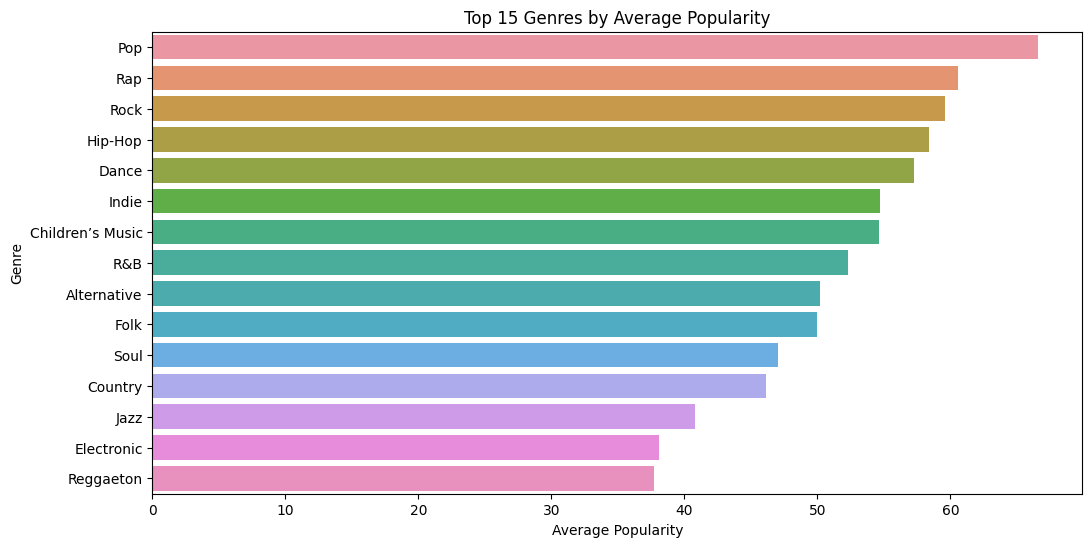

In [ ]:
genre_pop = df.groupby('genre')['popularity'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_pop.values, y=genre_pop.index)
plt.title("Top 15 Genres by Average Popularity")
plt.xlabel("Average Popularity")
plt.ylabel("Genre")
plt.show()


### Running Linear Regression

In [ ]:
# Feature matrix + intercept
Xmat = np.column_stack([np.ones(len(X)), X.values])
yvec = y_reg.values

# Compute coefficients (OLS closed form)
beta = np.linalg.inv(Xmat.T @ Xmat) @ (Xmat.T @ yvec)

y_pred = Xmat @ beta

rmse = np.sqrt(np.mean((yvec - y_pred)**2))
sst = np.sum((yvec - yvec.mean())**2)
sse = np.sum((yvec - y_pred)**2)
r2 = 1 - sse/sst

print(f'RMSE = {rmse:.04f}, r2 = {r2:.4f}')

RMSE = 15.9208, r2 = 0.2339


The RMSE value tells us that on average, the model's prediction on a song's popularity differs by about 16 points. The r^2 value tells us that only around 23% of the variation in a song's popularity can be explained by audio features. This tells us that the audio features alone do not provide enough information to accurately predict popularity, and that other external features account for most of the variation.

### Logistic Regression (Gradient Descent Implementation)
We classify high vs low popularity using a hand-coded logistic regression.

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Prepare matrices
Xcl = np.column_stack([np.ones(len(X)), X.values])  # intercept
ycl = y_clf.values.reshape(-1,1)

# Initialize parameters
np.random.seed(0)
beta_cl = np.zeros((Xcl.shape[1], 1))

lr = 0.001
epochs = 5000

for i in range(epochs):
    z = Xcl @ beta_cl
    p = sigmoid(z)
    grad = Xcl.T @ (p - ycl)
    beta_cl -= lr * grad / len(Xcl)

beta_cl.flatten()

array([ 0.04338379,  0.07789851,  0.00223473, -0.01668339,  0.24752473,
       -0.0008661 , -0.08295461, -0.0804522 , -0.04323256, -0.06549591,
        0.05716433])

In [ ]:
probs = sigmoid(Xcl @ beta_cl).flatten()
preds = (probs >= 0.5).astype(int)

accuracy = (preds == y_clf.values).mean()
print(f'Accuracy = {accuracy:.4f}')

Accuracy = 0.4896


The logistic regression model correctly predicted high vs. low popularity songs only around 49% of the time, which is essentially as effective as randomly guessing. This suggests that the audio features in the data set do not provide sufficient information to reliably distinguish the popularity of a song. 

### Manual K-Fold Cross-Validation

In [ ]:
def ols(X_train, y_train):
    return np.linalg.inv(X_train.T @ X_train) @ (X_train.T @ y_train)

def rmse_func(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

K = 5
fold_size = len(X) // K
rmse_scores = []

indices = np.arange(len(X))

for k in range(K):
    test_idx = indices[k*fold_size:(k+1)*fold_size]
    train_idx = np.delete(indices, test_idx)

    X_train = np.column_stack([np.ones(len(train_idx)), X.iloc[train_idx].values])
    y_train = y_reg.iloc[train_idx].values

    X_test = np.column_stack([np.ones(len(test_idx)), X.iloc[test_idx].values])
    y_test = y_reg.iloc[test_idx].values

    beta_k = ols(X_train, y_train)
    preds_k = X_test @ beta_k

    rmse_scores.append(rmse_func(y_test, preds_k))

rmse_cv_mean = np.mean(rmse_scores)
rmse_cv_std = np.std(rmse_scores)

print(f'RMSE = {rmse_cv_mean:.4f}, std. dev. = {rmse_cv_std:.4f}')

RMSE = 16.5275, std. dev. = 1.9397


The cross-validated RMSE was approximately 16.53 with a std. dev. of 1.94, indicating that the regression model consistently predicts popularity with an average error of around 16 points. The relatively small variability suggests that the model’s performance is stable, though the predictive capability is modest.

In [ ]:
def fit_logistic(X_train, y_train, lr=0.001, epochs=2000):
    beta = np.zeros((X_train.shape[1], 1))
    for i in range(epochs):
        p = sigmoid(X_train @ beta)
        grad = X_train.T @ (p - y_train)
        beta -= lr * grad / len(X_train)
    return beta

acc_scores = []

for k in range(K):
    test_idx = indices[k*fold_size:(k+1)*fold_size]
    train_idx = np.delete(indices, test_idx)

    X_train = np.column_stack([np.ones(len(train_idx)), X.iloc[train_idx].values])
    y_train = y_clf.iloc[train_idx].values.reshape(-1,1)

    X_test = np.column_stack([np.ones(len(test_idx)), X.iloc[test_idx].values])
    y_test = y_clf.iloc[test_idx].values

    beta_k = fit_logistic(X_train, y_train)
    
    probs = sigmoid(X_test @ beta_k).flatten()
    preds = (probs >= 0.5).astype(int)
    acc_scores.append((preds == y_test).mean())

print(f'Accuracy avg. = {np.mean(acc_scores):.4f}, std. dev. = {np.std(acc_scores):.4f}')

Accuracy avg. = 0.5645, std. dev. = 0.1107


The cross-validated accuracy averaged 56.5% with high std. dev. of about 11%. This indicates that the logistic regression classifier performs only slightly better than random guessing. This suggests weak and unstable predictive ability as some folds could perform well while others perform poorly.

### Bootstrap Confidence Intervals
##### Bootstrap CI for Mean Loudness Difference

In [ ]:
high = df[df['high_popularity']==1]['loudness'].values
low  = df[df['high_popularity']==0]['loudness'].values

obs = high.mean() - low.mean()

B = 2000
boot = []

rng = np.random.default_rng(42)

for _ in range(B):
    hb = rng.choice(high, len(high), replace=True)
    lb = rng.choice(low,  len(low),  replace=True)
    boot.append(hb.mean() - lb.mean())

ci_low, ci_high = np.percentile(boot, [2.5, 97.5])

print(f'Mean difference = {obs:.4f}, Confidence interval = {ci_low, ci_high}')

Mean difference = 3.8628, Confidence interval = (3.8167474717328873, 3.912405087745771)


The observed mean loudness difference between high-popularity and low-popularity tracks was about 3.86 dB. This indicates popular songs tend to be louder on average.

##### Bootstrap CI for Logistic Regression Accuracy

In [ ]:
probs_full = sigmoid(Xcl @ beta_cl).flatten()
preds_full = (probs_full >= 0.5).astype(int)
truth = y_clf.values

B = 2000
boot_acc = []

for _ in range(B):
    idx = rng.integers(0, len(truth), len(truth))
    boot_acc.append((preds_full[idx] == truth[idx]).mean())

np.percentile(boot_acc, [2.5, 97.5])

array([0.48756467, 0.4916039 ])

The bootstrap confidence interval for logistic regression accuracy ranged from 48.76% to 49.16%, which is essentially at or slightly below random-guessing performance.

### Feature Importance

In [ ]:
coef_df = pd.DataFrame({
    "feature": ["intercept"] + features,
    "coef": beta
})

print(coef_df.sort_values("coef", ascending=False))

             feature       coef
0          intercept  55.388910
1       danceability  17.739603
4           loudness   0.715112
10      duration_min   0.147424
5              tempo  -0.004275
7   instrumentalness  -4.310666
2             energy  -5.628317
8        speechiness  -8.107990
9           liveness  -9.670610
6       acousticness -11.935158
3            valence -13.225980


These results can be interpreted by seeing highly positive coefficients as indicating a strong positive association with popularity and highly negative coefficients as indicating a strong negative association with popularity.

# 5. Interpretation and Reporting